# Learn Deep Learning by Learning Julia

Everyone wants to make learning deep learning easier... what if we try to learn two things at once to keep it more interesting? This notebook teaches deep learning from the basics up, while teaching the required bits of the Julia programming language. I try to keep things as practical/concrete as possible, but where I think it is much clearer to use some mathematical notation I do.

While Python is by the far the most popular language for doing deep learning it is in many ways a very poor choice (of language, the ecosystem is amazing) as it has a very weak type system and relatively poor performance.

Julia gives us a more modern language, better performance and has some relevant super powers with respect to deep learning: we can write high level Julia code and both be able to automatically get gradients for functions (a key part of deep learning) and run it on GPUs (key for performance).

## 1 Assumptions

* You already know a programming language like Python, R or Javascript
* You know basic linear algebra
* Have installed [Anaconda](https://www.anaconda.com/) (easy way to get Jupyter + deps)
* Have installed [Julia 1.1](https://julialang.org/)

Then

* Start with `jupyter notebook`
* Open this or create a new Julia 1.1. notebook.

Jupyter notebook has two modes: edit and command. Esc enters command mode from edit mode. Enter does the opposite. Print this [cheat sheet](jupyter-shortcuts.pdf) (for Mac) or hit `h` in command mode to see shortcuts.

## 2 Basic Julia

(It works mostly like you'd expect)

In [1]:
print("hello world")

hello world

In [2]:
4 + 3

7

Julia has support for concise/clear definition of functions.

In [3]:
f(x) = x + 1
f(5)

6

And anonymous functions

In [4]:
x -> x + 1

#3 (generic function with 1 method)

Julia has built in support for maths on vectors (e.g. elementwise ops use a . in front of standard operator) and a nice syntax for doing vectors and matrices

In [5]:
[1 2 3] .* [3 4 5]

1×3 Array{Int64,2}:
 3  8  15

In [6]:
[1 2; 4 5]

2×2 Array{Int64,2}:
 1  2
 4  5

In [7]:
[1 3; 6 7] * [-1 0; 1 2]

2×2 Array{Int64,2}:
 2   6
 1  14

Julia starts indexing from 1, which is way more standard in mathematics/science than the 0 based indexing you may be used to from most programming languages

In [105]:
[1,2,3][1]

1

Julia has the awesome pipeline operator `|>` for clearly combining functions. No(ridiculous(nested(brackets))). Take an input pass it to a function, then pass output to next function and so on. Even Javascript is (hopefully) [adding this](https://github.com/tc39/proposal-pipeline-operator)

In [8]:
5 |> f |> f |> x -> x * 2 

14

## 3 A very simple neural network

Neural networks basically take an input of some numbers and produce an output of some numbers.

To use packages in Julia we use `using` to import

In [9]:
using LinearAlgebra

In [10]:
function simple_nn(input)
   dot(input, [0.1 0.3 0.2]) 
end


simple_nn([0.4 0.2 0.1])

0.12000000000000001

Yes, it is just a weighted sum (dot product of some input with some hardcoded values). The input could be some observed characteristics and the output a prediction of membership of a group. 

We can also do a multi-input, multi-output network (yes this is just matrix multiplication):

In [11]:
function simple_nn2(input)
   input * [0.1 0.2 0.3; 0.4 -0.1 0.1; 0.1 0.4 0.2] 
end

simple_nn2([0.4 0.2 0.1])

1×3 Array{Float64,2}:
 0.13  0.1  0.16

Typically we will stack multiple neural networks. Let's combine the two we have used so far (using the pipeline operator for clarity):

In [12]:
[0.1 0.2 0.3] |> simple_nn2 |> simple_nn

0.07

## 4 Gradient Descent (i): a simple way to learn

So we can make very simple neural networks. But how do they learn? How do we update the weights? We'll start with a very simple gradient descent process for a trivial model.

In [13]:
prediction(x, weight) = x * weight

prediction (generic function with 1 method)

We want a way of calculating the error. A standard approach is Mean Squared Error (mse)

In [26]:
mse(pred, actual) = (pred - actual) ^ 2

mse (generic function with 1 method)

In [27]:
input = 0.4
goal = 0.32
weight = 0.5 # 'correct' weight is 0.8, want to learn this

p = prediction(input, weight)
mse(p, goal)

0.0144

Okay so we have an error for this trivial, fake situation. But how would we update the weight to improve (reduce the error)? Let's multiply the absolute error by the input.

In [22]:
abserr_times_input = (p - goal) * input
abserr_times_input

-0.048

Now let's adjust the weights:

In [23]:
new_weight = weight - abserr_times_input

0.548

In [24]:
input = 0.4

p2 = prediction(input, new_weight)
mse(p2, goal)

0.010160639999999995

Let's try iterating

In [33]:
w = new_weight

for i = 1:10
    p = prediction(input, w)
    delta = (p - goal)
    w -= delta
    np = prediction(input, w)
    print("($(i)) Weight $(w) MSE $(mse(np, goal))\n")
end

(1) Weight 0.6488 MSE 0.0036578303999999975
(2) Weight 0.70928 MSE 0.001316818943999999
(3) Weight 0.745568 MSE 0.0004740548198399992
(4) Weight 0.7673407999999999 MSE 0.00017065973514240057
(5) Weight 0.78040448 MSE 6.14375046512642e-5
(6) Weight 0.788242688 MSE 2.2117501674455113e-5
(7) Weight 0.7929456128 MSE 7.962300602803653e-6
(8) Weight 0.7957673676799999 MSE 2.8664282170095032e-6
(9) Weight 0.7974604206079999 MSE 1.0319141581234438e-6
(10) Weight 0.7984762523647999 MSE 3.7148909692445324e-7


As you can see at each step we are reducing the error and getting close to the correct solution

## 5 Gradient Descent (ii): using derivatives

Okay so what are we really doing? **Gradient descent works by making a series of steps. In each step we subtract a scaled partial derivative of the error from each of the current parameters.** (Subtracting means we should be moving in the right direction, scaling that we hopefully aren't overshooting the optimal value.)

In the above example our model has just one parameter (the weight), so we just take a standard derivative.

$mse(w) = (0.4 w - 0.32) ^2$
$mse(w) = (0.16 w^2 - 0.256 w + 0.1024)$

So differentiating:

$\frac{dmse(w)}{dw} = 0.32w - 0.256$


In [54]:
dmse(w) = 0.32 * w - 0.256

dmse (generic function with 1 method)

This is the slope of the mean squared error. Let's see what this looks like (if you already have Plots installed skip).

In [92]:
using Pkg
Pkg.add("Plots")
Pkg.add("PyPlot")

 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [93]:
using Plots

In [103]:
# using the Python PyPlot backend as it seems to work reliably with Jupyter
Plots.pyplot()

Plots.PyPlotBackend()

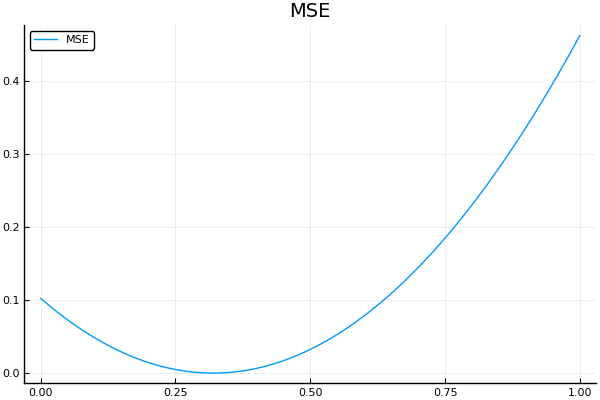

In [104]:
grid = (0:100)*0.01
Plots.plot(grid, map(x -> mse(x, 0.32), grid),linewidth=1,title="MSE", label="MSE")

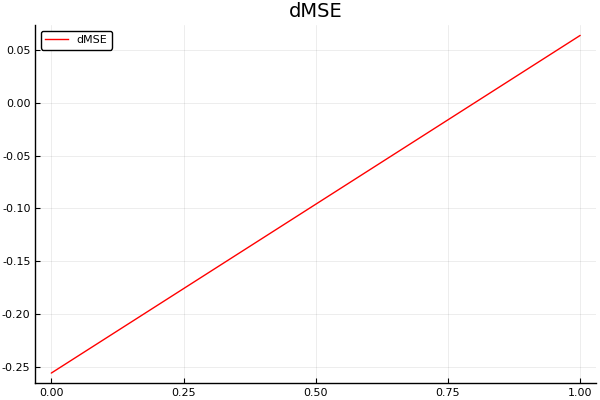

In [102]:
grid = (0:100)*0.01
Plots.plot(grid, map(dmse, grid),linewidth=1,title="dMSE", label="dMSE", color="red")

Notice how it is negative below 0.8 and positive above. So if we update our weight using the slope we can close in on the correct weight.

In [60]:
w = 0.9

for i = 1:10
    w -= dmse(w)
    np = prediction(input, w)
    print("($(i)) Weight $(w) MSE $(mse(np, goal))\n")
end

(1) Weight 0.868 MSE 0.0007398400000000001
(2) Weight 0.84624 MSE 0.0003421020160000005
(3) Weight 0.8314432 MSE 0.0001581879721984006
(4) Weight 0.821381376 MSE 7.31461183445406e-5
(5) Weight 0.81453933568 MSE 3.382276512251596e-5
(6) Weight 0.8098867482624 MSE 1.5639646592651166e-5
(7) Weight 0.806722988818432 MSE 7.231772584441816e-6
(8) Weight 0.8045716323965337 MSE 3.3439716430459365e-6
(9) Weight 0.803108710029643 MSE 1.5462524877444742e-6
(10) Weight 0.8021139228201573 MSE 7.1498715033312e-7


Typically we will also scale, to avoid problems with overshooting. (In this example it will slow things down, but in more realistic scenarios this kind of adjustment is vital.)

In [97]:
w = 0.9
a = 0.1

for i = 1:10
    w -= a * dmse(w)
    np = prediction(input, w)
    print("($(i)) Weight $(w) MSE $(mse(np, goal))\n")
end

(1) Weight 0.8968 MSE 0.0014992384000000025
(2) Weight 0.8937024 MSE 0.0014048223625216006
(3) Weight 0.8907039232 MSE 0.0013163522694194423
(4) Weight 0.8878013976576 MSE 0.0012334536689004821
(5) Weight 0.8849917529325568 MSE 0.0011557756906478047
(6) Weight 0.882272016838715 MSE 0.00108298956075357
(7) Weight 0.8796393122998761 MSE 0.001014787210175554
(8) Weight 0.8770908543062801 MSE 0.0009508799708275368
(9) Weight 0.8746239469684791 MSE 0.0008909973537847009
(10) Weight 0.8722359806654878 MSE 0.000834885904432756


## 6 Gradient Descent (iii): Learn multiple weights

So far we have only done gradient descent for a single input, but typically in deep learning we want to learn many weights at once. We'll look at that now. Let's pretend we now have 3 inputs, 3 weights (to learn) and one output.

$g(x_1, x_2, x_3) = x_1 w_1 + x_2 w_2 + x_3 w_3$

Then the (mean squared) error is:

$mse = (x_1 w_1 + x_2 w_2 + x_3 w_3 - y)^2$

The (partial) derivative is basically the same as before (well the constant term is different).

$\frac{\partial mse}{\partial w_1} = 2x_1^2 w_1 + C$ 

where

$C = 2 x_1 (x_2 w_2 + x_3 w_ 3 - y)$

Now we can follow the same process as before: for some set of weights, calculate partial derivatives of error for each, then move along the slope. If the model and data are nice, this will work well, closing in on an optimum set of weights.

Let's implement that. Again let's fake and fix everything. Let's again make the target output $y = 0.8$ and inputs $0.2$, $0.4$ and $0.6$.

In [143]:
weights = [0.3, 0.1, 0.4]
input = [0.2, 0.4, 0.6]
goal = 0.8

0.8

In [144]:
function pdmse(i)
    # get the weights/input excluding current index
    w_excl = weights[1:end .!= i]
    i_excl = input[1:end .!= i]
     c = 2 * input[i] * (dot(w_excl, i_excl) - goal)
     2 * weights[i] * input[i] ^ 2 + c
end

pdmse (generic function with 1 method)

In [145]:
prediction(ipt, weights) = dot(ipt, weights)

prediction (generic function with 1 method)

In [146]:
prediction(input, weights)

0.33999999999999997

In [153]:
weights = [0.3, 0.1, 0.4]
input = [0.2, 0.4, 0.6]
goal = 0.8

print("Start with weights $(weights)\n")
for i = 1:20
    for (idx, w) in enumerate(weights)
       weights[idx] -= 0.1 * pdmse(idx)
    end
    
    np = dot(input, weights)
    print("($(i)) Weights $(weights) MSE $(mse(np, goal))\n")
end

Start with weights [0.3, 0.1, 0.4]
(1) Weights [0.3184, 0.136506, 0.453006] MSE 0.1680295540316265
(2) Weights [0.334797, 0.169036, 0.500241] MSE 0.13343067593604574
(3) Weights [0.349408, 0.198025, 0.542332] MSE 0.10595603483777045
(4) Weights [0.362428, 0.223858, 0.579841] MSE 0.08413868280127618
(5) Weights [0.374031, 0.246877, 0.613266] MSE 0.06681373037763197
(6) Weights [0.38437, 0.26739, 0.643051] MSE 0.053056149898595646
(7) Weights [0.393584, 0.28567, 0.669593] MSE 0.0421313856620801
(8) Weights [0.401794, 0.30196, 0.693245] MSE 0.03345613394864732
(9) Weights [0.409111, 0.316475, 0.714322] MSE 0.026567198804411975
(10) Weights [0.41563, 0.329411, 0.733104] MSE 0.021096760713491952
(11) Weights [0.42144, 0.340937, 0.749841] MSE 0.016752737685255172
(12) Weights [0.426618, 0.351209, 0.764756] MSE 0.0133031901798783
(13) Weights [0.431231, 0.360362, 0.778046] MSE 0.010563937207574954
(14) Weights [0.435342, 0.368519, 0.78989] MSE 0.008388722390391887
(15) Weights [0.439006, 0.37